# 14. Calibration over (lossy) splices and connectors

## Background
While it is best practice to not have connectors or splices within a DTS calibration, sometimes it can't be avoided. For example, in a borehole the fibers in a duplex cable are often connected with either a splice or a loopback connector. 

Splices and connectors will cause a step loss in the signal strength, and with varying strain and temperature, this step loss will vary. In double ended setups this step loss can even be asymmetrical for the forward and backward measurements. All these effects have to be taken into account in the calibration.

To calibrate over these splices/connectors, locations with 'transient attenuation' can be defined along the length of the fiber. Adding these does mean that more information is needed to perform the calibration, such as extra reference sections or matching sections of fiber. Matching sections will be explained in notebook 15.



### Demonstration
To demonstrate the effect of a lossy splice, we'll load the same dataset that was used in previous notebooks, and modify the data to simulate a lossy splice.

In [1]:
import os

from dtscalibration import read_silixa_files
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
filepath = os.path.join('..', '..', 'tests', 'data', 'double_ended2')

ds_ = read_silixa_files(
    directory=filepath,
    timezone_netcdf='UTC',
    file_ext='*.xml')

ds = ds_.sel(x=slice(0, 110))  # only calibrate parts of the fiber


sections = {
    'probe1Temperature': [slice(7.5, 17.), slice(70., 80.)],  # cold bath
    'probe2Temperature': [slice(24., 34.), slice(85., 95.)],  # warm bath
    }
ds.sections = sections

6 files were found, each representing a single timestep
6 recorded vars were found: LAF, ST, AST, REV-ST, REV-AST, TMP
Recorded at 1693 points along the cable
The measurement is double ended
Reading the data from disk


/Volumes/GoogleDrive/My Drive/Projects/python-dts-calibration/src/dtscalibration/io.py:1843: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  'time', pd.DatetimeIndex(v).tz_convert(timezone_netcdf).astype(


To simulate the lossy splice, we introduce a step loss in the signal strength at x = 50 m. For the forward channel, this means all data beyond 50 meters is reduced with a 'random' factor. For the backward channel, this means all data up to 50 meters is reduced with a 'random' factor.

In the plots of the Stokes and anti-Stokes signal the big step loss is clearly visible.

In [3]:
ds['st'] = ds.st.where(ds.x < 50, ds.st*.8)
ds['ast'] = ds.ast.where(ds.x < 50, ds.ast*.82)

ds['rst'] = ds.rst.where(ds.x > 50, ds.rst*.85)
ds['rast'] = ds.rast.where(ds.x > 50, ds.rast*.81)

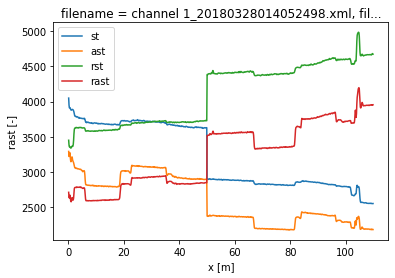

In [4]:
ds.isel(time=0).st.plot(label='st')
ds.isel(time=0).ast.plot(label='ast')
ds.isel(time=0).rst.plot(label='rst')
ds.isel(time=0).rast.plot(label='rast')
plt.legend()

We will first run a calibration without adding the transient attenuation location. A big jump in the calibrated temperature is visible at x = 50, and all temperatures before the jump are too low, and the temperatures after the jump are too high.

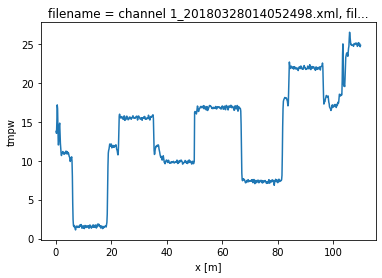

In [5]:
ds_a = ds.copy(deep=True)

st_var, resid = ds_a.variance_stokes(st_label='st')
ast_var, _ = ds_a.variance_stokes(st_label='ast')
rst_var, _ = ds_a.variance_stokes(st_label='rst')
rast_var, _ = ds_a.variance_stokes(st_label='rast')

ds_a.calibration_double_ended(
    st_var=st_var,
    ast_var=ast_var,
    rst_var=rst_var,
    rast_var=rast_var,
    store_tmpw='tmpw',
    method='wls',
    solver='sparse')

ds_a.isel(time=0).tmpw.plot(label='calibrated')

Now we run a calibration, adding the keyword argument '**trans_att**', and provide a list of floats containing the locations of the splices. In this case we only add a single one at x = 50 m. After running the calibration you will see that by adding the transient attenuation location the calibration returns the correct temperature, without the big jump.

*In single-ended calibration the keyword is called '**trans_att**'.*

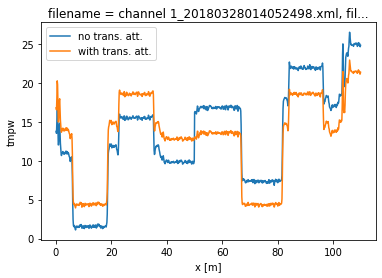

In [6]:
st_var, resid = ds.variance_stokes(st_label='st')
ast_var, _ = ds.variance_stokes(st_label='ast')
rst_var, _ = ds.variance_stokes(st_label='rst')
rast_var, _ = ds.variance_stokes(st_label='rast')

ds.calibration_double_ended(
    st_var=st_var,
    ast_var=ast_var,
    rst_var=rst_var,
    rast_var=rast_var,
    trans_att=[50.],
    store_tmpw='tmpw',
    method='wls',
    solver='sparse')

ds_a.isel(time=0).tmpw.plot(label='no trans. att.')
ds.isel(time=0).tmpw.plot(label='with trans. att.')
plt.legend()